In [1]:
import tqdm
import itertools

import datamol as dm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mood.constants import RESULTS_DIR
from mood.dataset import MOOD_DATASETS
from mood.representations import MOOD_REPRESENTATIONS
from mood.baselines import MOOD_BASELINES
from mood.utils import get_outlier_bounds
from mood.metrics import Metric

/home/cas/local/conda/envs/mood_v2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SUBDIR = "20221213"

In [3]:
in_dir = dm.fs.join(RESULTS_DIR, "dataframes", "compare_performance", SUBDIR)
pattern = dm.fs.join(in_dir, "gap_*.csv")
paths = dm.fs.glob(pattern)

In [4]:
def find_missing(paths, all_triplets):
    triplets = []
    for path in paths:
        path = dm.fs.get_basename(path)
        path = ".".join(path.split(".")[:-1])
        triplet = tuple(path.split("_")[1:])
        triplets.append(triplet)
    missing = set(all_triplets) - set(triplets)
    
    msg = f"Missing {len(missing)}:\n"
    for m in sorted(missing): 
        msg += f"{m}\n"
    return msg 
                        

all_triplets = list(itertools.product(MOOD_DATASETS, MOOD_BASELINES, MOOD_REPRESENTATIONS))
assert len(list(all_triplets)) == len(paths), find_missing(paths, all_triplets)

In [5]:
df_original = pd.concat([pd.read_csv(p) for p in tqdm.tqdm(paths)], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:48<00:00,  4.09it/s]


In [6]:
df_original.groupby(["type", "metric"])[["iid_score", "ood_score"]].describe()

iid_score                                            \
                            count       mean        std       min       25%   
type        metric                                                            
calibration Brier score     108.0   0.251134   0.122434  0.059324  0.155774   
            Spearman         90.0   0.235343   0.181567 -0.215911  0.109291   
performance AUROC           108.0   0.755658   0.067784  0.499604  0.719024   
            MAE              90.0  16.479915  26.817056  0.307306  0.641901   

                                                         ood_score             \
                              50%        75%         max     count       mean   
type        metric                                                              
calibration Brier score  0.245319   0.338630    0.596698     108.0   0.264642   
            Spearman     0.221120   0.358215    0.673074      90.0   0.186894   
performance AUROC        0.758054   0.802975    0.887637     108.0   0.722437   
            MAE          9.997372  23.094781  231.291733      90.0  17.064197   

                                                                              \
                               std       min       25%        50%        75%   
type        metric                                                             
calibration Brier score   0.143182  0.042731  0.139543   0.252572   0.360566   
            Spearman      0.188679 -0.188237  0.035257   0.169481   0.315155   
performance AUROC         0.064405  0.503769  0.691346   0.728018   0.762533   
            MAE          21.392984  0.311015  0.775051  11.374368  28.477154   

                                     
                                max  
type        metric                   
calibration Brier score    0.727216  
            Spearman       0.676177  
performance AUROC          0.876457  
            MAE          159.147614

In [7]:
# Make a copy to keep the original intact. 
# Useful for experimentation, as creating the dataframe can be slow
df = df_original.copy()

# Upscale the Spearman correlation to go from [-1, 1] to [0, 1]
df.loc[df["metric"] == "Spearman", "iid_score"] = (df["iid_score"] + 1) / 2
df.loc[df["metric"] == "Spearman", "ood_score"] = (df["ood_score"] + 1) / 2

# A gap > 0; performance on OOD set was better
# We expect: Performance to be worse (so: Negative gaps)
df["gap"] = df["ood_score"] - df["iid_score"]

# We can also compute the relative change
# This is useful as the range to values for all targets is not the same (e.g. PPBR vs. Caco-2)
df["relative_gap"] = (df["gap"] / df["iid_score"]) * 100

# Invert the gap of metrics that need to be minimized, so that a high gap is always better
df["metric_direction"] = df["metric"].apply(lambda x: Metric.by_name(x).mode)
df.loc[df["gap"] == "min", "gap"] = -df["gap"]
df.loc[df["metric_direction"] == "min", "relative_gap"] = -df["relative_gap"]

df = df.rename(columns={"representation": "Representation", "dataset": "Dataset"})
df.head()

,Dataset,algorithm,Representation,iid_score,ood_score,metric,type,gap,relative_gap,metric_direction
0,BBB,GP,ChemBERTa,0.777683,0.703392,AUROC,performance,-0.074291,-9.552875,max
1,BBB,GP,ChemBERTa,0.170960,0.164108,Brier score,calibration,-0.006852,4.008094,min
2,BBB,GP,Desc2D,0.777883,0.779799,AUROC,performance,0.001916,0.246347,max
3,BBB,GP,Desc2D,0.137008,0.146016,Brier score,calibration,0.009008,-6.574931,min
4,BBB,GP,ECFP6,0.782923,0.610287,AUROC,performance,-0.172636,-22.050209,max


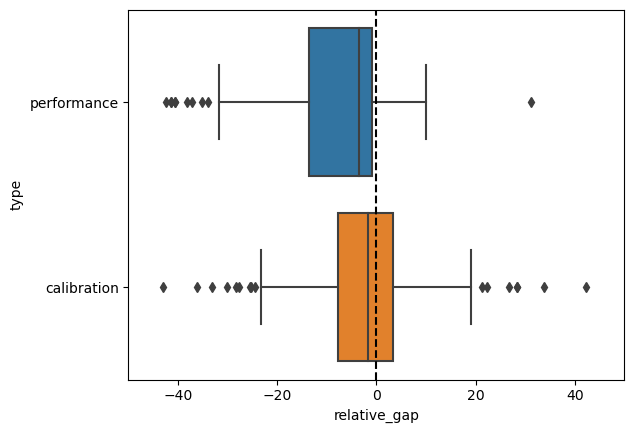

In [8]:
ax = sns.boxplot(data=df, x="relative_gap", y="type")
ax.set_xlim([-50, 50])
ax.plot([0, 0], ax.get_ylim(), "k--")

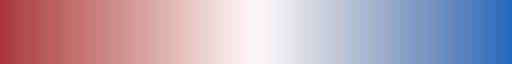

In [9]:
cmap = sns.color_palette("vlag_r", as_cmap=True)
cmap

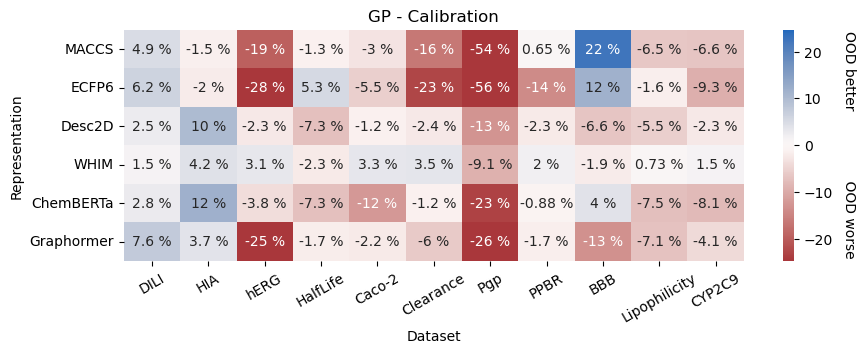

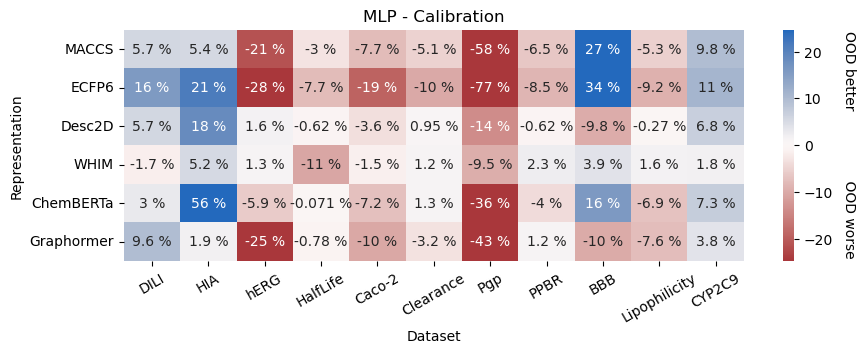

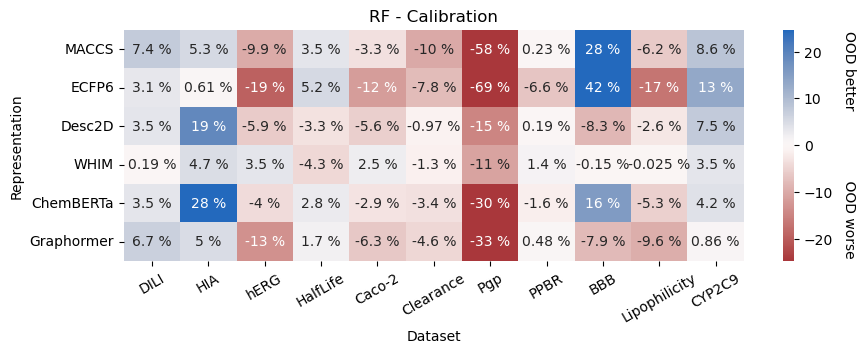

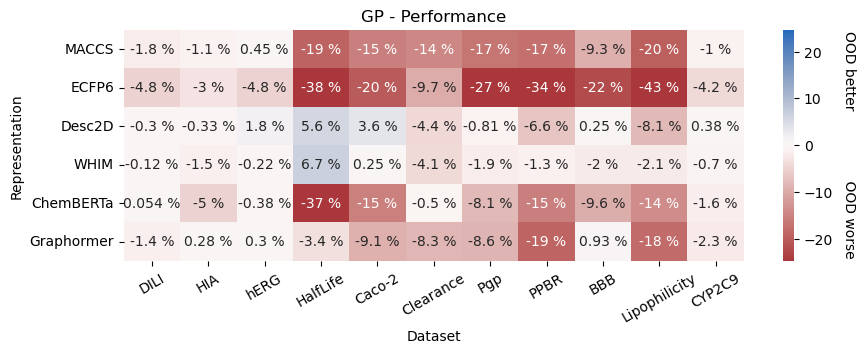

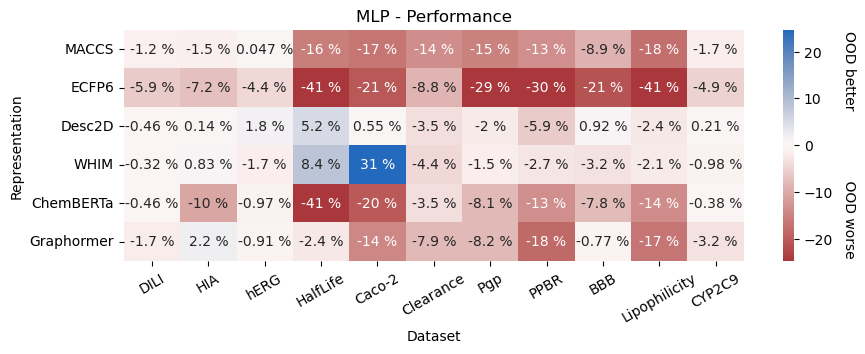

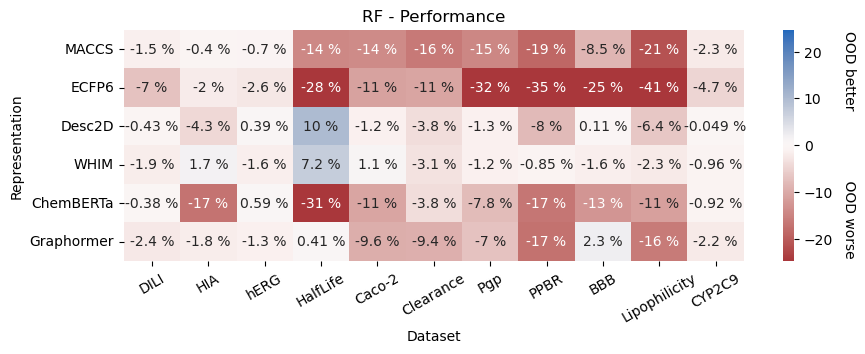

In [10]:
metric = "relative_gap"

lower, upper = get_outlier_bounds(df[metric].to_numpy())
vmin = min(lower, -upper)
vmax = -vmin

for metric_type, metric_group in df.groupby("type"):
        
    for idx, (name, group) in enumerate(metric_group.groupby("algorithm")):
        fig, ax = plt.subplots(figsize=(10, 3))
        pivot = group.pivot("Representation", "Dataset", metric)
        
        for c in MOOD_DATASETS: 
            if c not in pivot.columns:
                pivot[c] = np.nan
        pivot = pivot[MOOD_DATASETS]
        pivot = pivot.reindex(MOOD_REPRESENTATIONS)
        
        sns.heatmap(pivot, annot=True, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        for t in ax.texts: t.set_text(t.get_text() + " %")
        ax.set_title(f"{name} - {metric_type.capitalize()}")
        ax.text(
            0.85, 
            0.5, 
            f"{'OOD better':25} OOD worse", 
            rotation=-90, 
            ha="center", 
            va="center", 
            transform=fig.transFigure
        )

The End.